# **Spaceship Titanic**

# **Project Description**

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good. The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars. While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension! To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system. Help save them and change history!

# **Goals**

Get highest classification accuracy score calculated by percentage of predicted labels for transported passengers

# **1.Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna

import torch
import torch.nn as nn
import torch.optim as optim

from ydata_profiling import ProfileReport

import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, RocCurveDisplay

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

Because data size is acceptable for memory capacity we're reading entire data from csv to DataFrame.

In [2]:
TRAIN_DATA_PATH = 'data/train.csv'
TEST_DATA_PATH = 'data/test.csv'

In [3]:
train = pd.read_csv(TRAIN_DATA_PATH, index_col=False)
test = pd.read_csv(TEST_DATA_PATH, index_col=False)

# **2.Data processing**

**Data Field Descriptions**

```PassengerId``` - A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and `pp` is their number within the group. People in a group are often family members, but not always.

```HomePlanet``` - The planet the passenger departed from, typically their planet of permanent residence.

```CryoSleep``` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

```Cabin``` - The cabin number where the passenger is staying. Takes the form `deck/num/side`, where `side` can be either `P` for Port or `S` for Starboard.

```Destination``` - The planet the passenger will be debarking to.

```Age``` - The age of the passenger.

```VIP``` - Whether the passenger has paid for special VIP service during the voyage.

```RoomService```, ```FoodCourt```, ```ShoppingMall```, ```Spa```, ```VRDeck``` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

```Name``` - The first and last names of the passenger.

```Transported``` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

**Few steps before we start data analysis**

As was mentioned above each ```PassengerId``` takes the form `gggg_pp`, ```Cabin``` takes the form `deck/num/side` and ```Name``` contains first and last name my first step will be creating new columns from those features.

In [4]:
temp = pd.concat([train, test]).copy()

In [5]:
def split_passenger_id(df):
    df[['Group', 'pp']] = df.PassengerId.str.split('_', expand=True)
    return df

In [6]:
def split_cabin(df):
    df[['Deck', 'Num', 'Side']] = df.Cabin.str.split('/', expand=True)
    df.drop(columns='Cabin',axis=1, inplace=True)
    return df

In [7]:
def split_name(df):
    df[['FirstName', 'LastName']] = df.Name.str.split(' ', expand=True)
    df.drop(columns='Name',axis=1, inplace=True)
    return df

In [8]:
temp = (temp
        .pipe(split_passenger_id)
        .pipe(split_cabin)
        .pipe(split_name)
        )

## **2.1 Background information**

In [9]:
def get_number_of_null_cells_in_row(df):
    return df.isnull().sum(axis=1).value_counts()

In [10]:
temp

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,pp,Deck,Num,Side,FirstName,LastName
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,01,B,0,P,Maham,Ofracculy
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,01,F,0,S,Juanna,Vines
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,01,A,0,S,Altark,Susent
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,02,A,0,S,Solam,Susent
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,01,F,1,S,Willy,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,NaN,9266,02,G,1496,S,Jeron,Peter
4273,9269_01,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,NaN,9269,01,NaN,NaN,NaN,Matty,Scheron
4274,9271_01,Mars,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,NaN,9271,01,D,296,P,Jayrin,Pore
4275,9273_01,Europa,False,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,NaN,9273,01,D,297,P,Kitakan,Conale


In [11]:
print(f"The number of rows in train data is {temp.shape[0]}, and the number of columns is {temp.shape[1]}")

The number of rows in train data is 12970, and the number of columns is 19


In [12]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Destination   12696 non-null  object 
 4   Age           12700 non-null  float64
 5   VIP           12674 non-null  object 
 6   RoomService   12707 non-null  float64
 7   FoodCourt     12681 non-null  float64
 8   ShoppingMall  12664 non-null  float64
 9   Spa           12686 non-null  float64
 10  VRDeck        12702 non-null  float64
 11  Transported   8693 non-null   object 
 12  Group         12970 non-null  object 
 13  pp            12970 non-null  object 
 14  Deck          12671 non-null  object 
 15  Num           12671 non-null  object 
 16  Side          12671 non-null  object 
 17  FirstName     12676 non-null  object 
 18  LastName      12676 non-nul

In [13]:
temp.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


<AxesSubplot: >

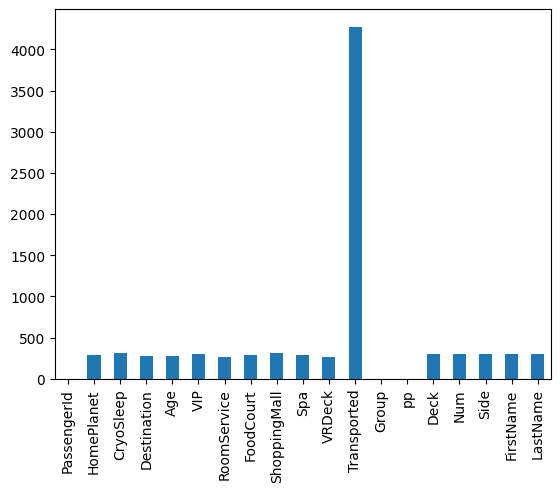

In [14]:
temp.isna().sum().plot(kind='bar')

In [15]:
get_number_of_null_cells_in_row(temp)

0    6606
1    4832
2    1012
3     354
4     140
5      24
6       2
dtype: int64

Approximately ~25% rows include null values that must be filled in.

<AxesSubplot: ylabel='Transported'>

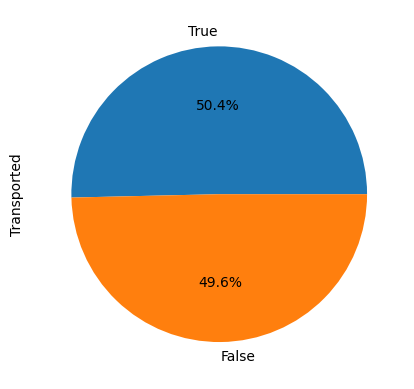

In [16]:
temp['Transported'].value_counts().plot(kind='pie', autopct='%1.1f%%')

As we can see train dataset is almost perfectly balanced.

### **2.1.1 Age --> Other**

In [17]:
temp

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,pp,Deck,Num,Side,FirstName,LastName
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,01,B,0,P,Maham,Ofracculy
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,01,F,0,S,Juanna,Vines
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,01,A,0,S,Altark,Susent
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,02,A,0,S,Solam,Susent
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,01,F,1,S,Willy,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,NaN,9266,02,G,1496,S,Jeron,Peter
4273,9269_01,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,NaN,9269,01,NaN,NaN,NaN,Matty,Scheron
4274,9271_01,Mars,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,NaN,9271,01,D,296,P,Jayrin,Pore
4275,9273_01,Europa,False,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,NaN,9273,01,D,297,P,Kitakan,Conale


<function matplotlib.pyplot.show(close=None, block=None)>

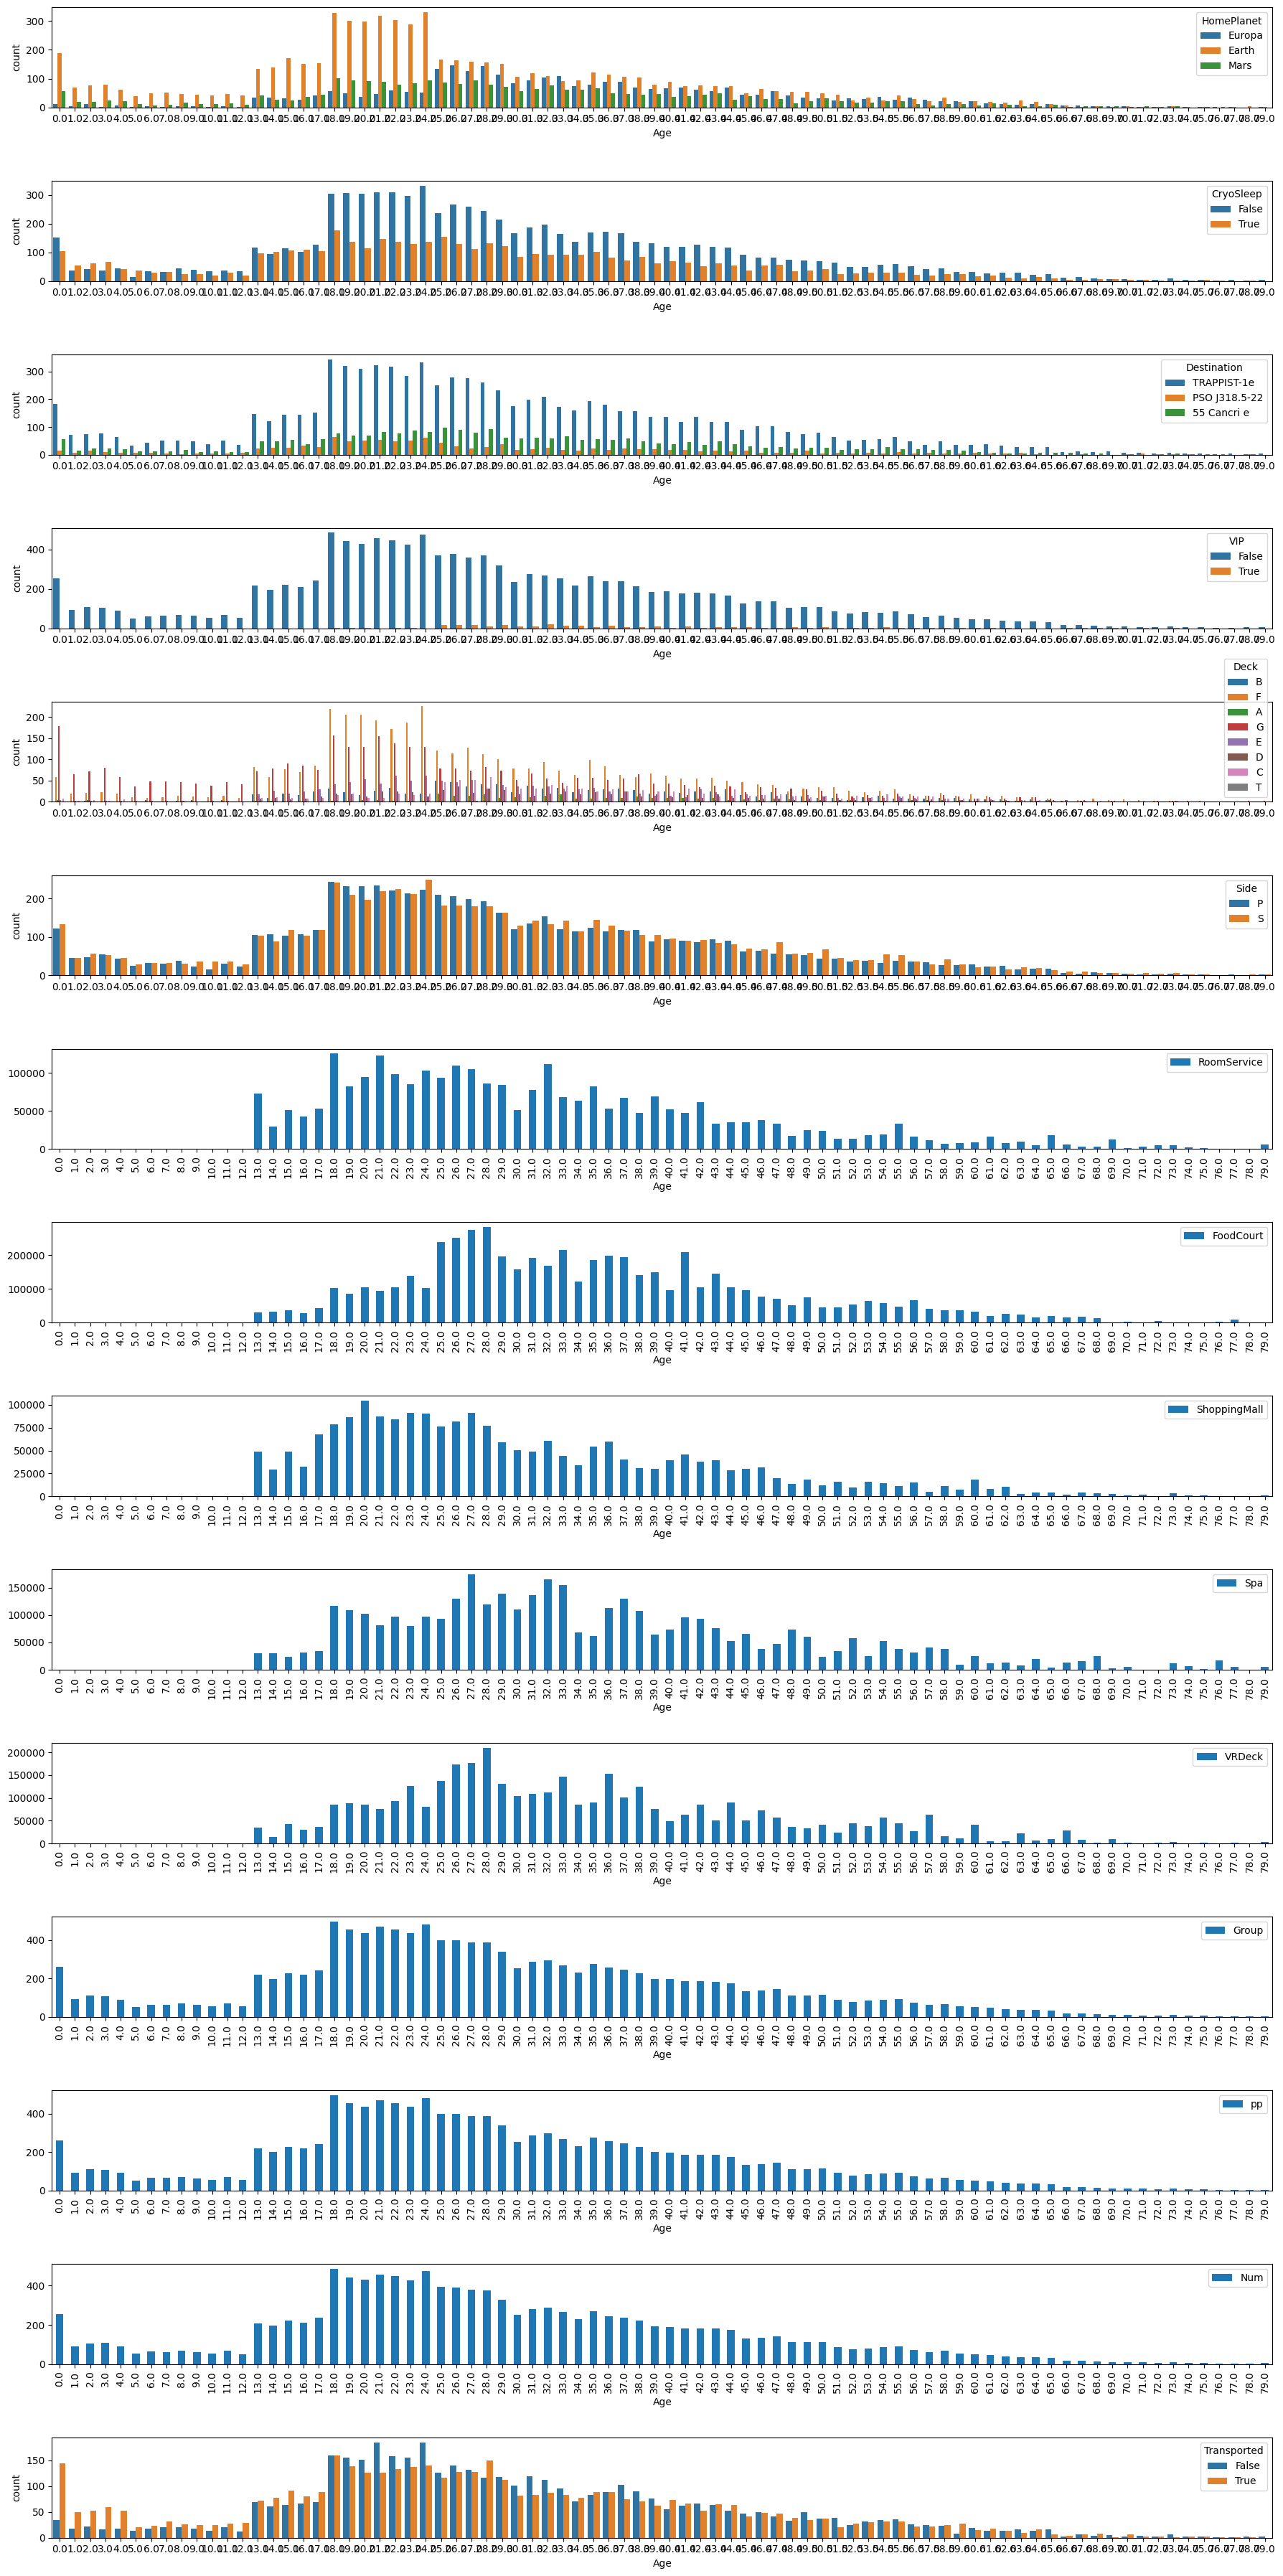

In [18]:
fig, ax = plt.subplots(15,figsize=(18,36))
sns.countplot(x='Age',hue='Transported',data=temp, ax=ax[14])
sns.countplot(x='Age',hue='HomePlanet',data=temp, ax=ax[0])
sns.countplot(x='Age',hue='CryoSleep',data=temp, ax=ax[1])
sns.countplot(x='Age',hue='Destination',data=temp, ax=ax[2])
sns.countplot(x='Age',hue='VIP',data=temp, ax=ax[3])
sns.countplot(x='Age',hue='Deck',data=temp, ax=ax[4])
sns.countplot(x='Age',hue='Side',data=temp, ax=ax[5])

temp.groupby('Age')['RoomService'].sum().plot(kind='bar', ax=ax[6], legend=True)
temp.groupby('Age')['FoodCourt'].sum().plot(kind='bar', ax=ax[7], legend=True)
temp.groupby('Age')['ShoppingMall'].sum().plot(kind='bar', ax=ax[8], legend=True)
temp.groupby('Age')['Spa'].sum().plot(kind='bar', ax=ax[9], legend=True)
temp.groupby('Age')['VRDeck'].sum().plot(kind='bar', ax=ax[10], legend=True)
temp.groupby('Age')['Group'].count().plot(kind='bar', ax=ax[11], legend=True)
temp.groupby('Age')['pp'].count().plot(kind='bar', ax=ax[12], legend=True)
temp.groupby('Age')['Num'].count().plot(kind='bar', ax=ax[13], legend=True)
fig.tight_layout()
plt.show

Age is a continuous feature were necessery is discretization which I do grouping some ages basing on visualization above.<br>
Groups:<br>
0 - age equal 0 many unborns/newborns was transported it might have impact for future training. <br>
1 - age 1-4 high transportation ratio <br>
2 - age 5-12 low count of persons in those age group i compare to other<br>
3 - age 13-17 the first group in which expenses appear<br>
4 - age 18-24 up to 24 age old only 4 VIP exist<br>
5 - age 25-65 others<br>
6 - age 66- count of persons above 66 years old is highly decrased

In [19]:
def group_age(df):
    df['Age'] = pd.cut(df['Age'], bins=[0,1,5,13,18,25,66,110], labels=[0,1,2,3,4,5,6], right=False)
    return df

### **2.1.2 HomePlanet --> other**

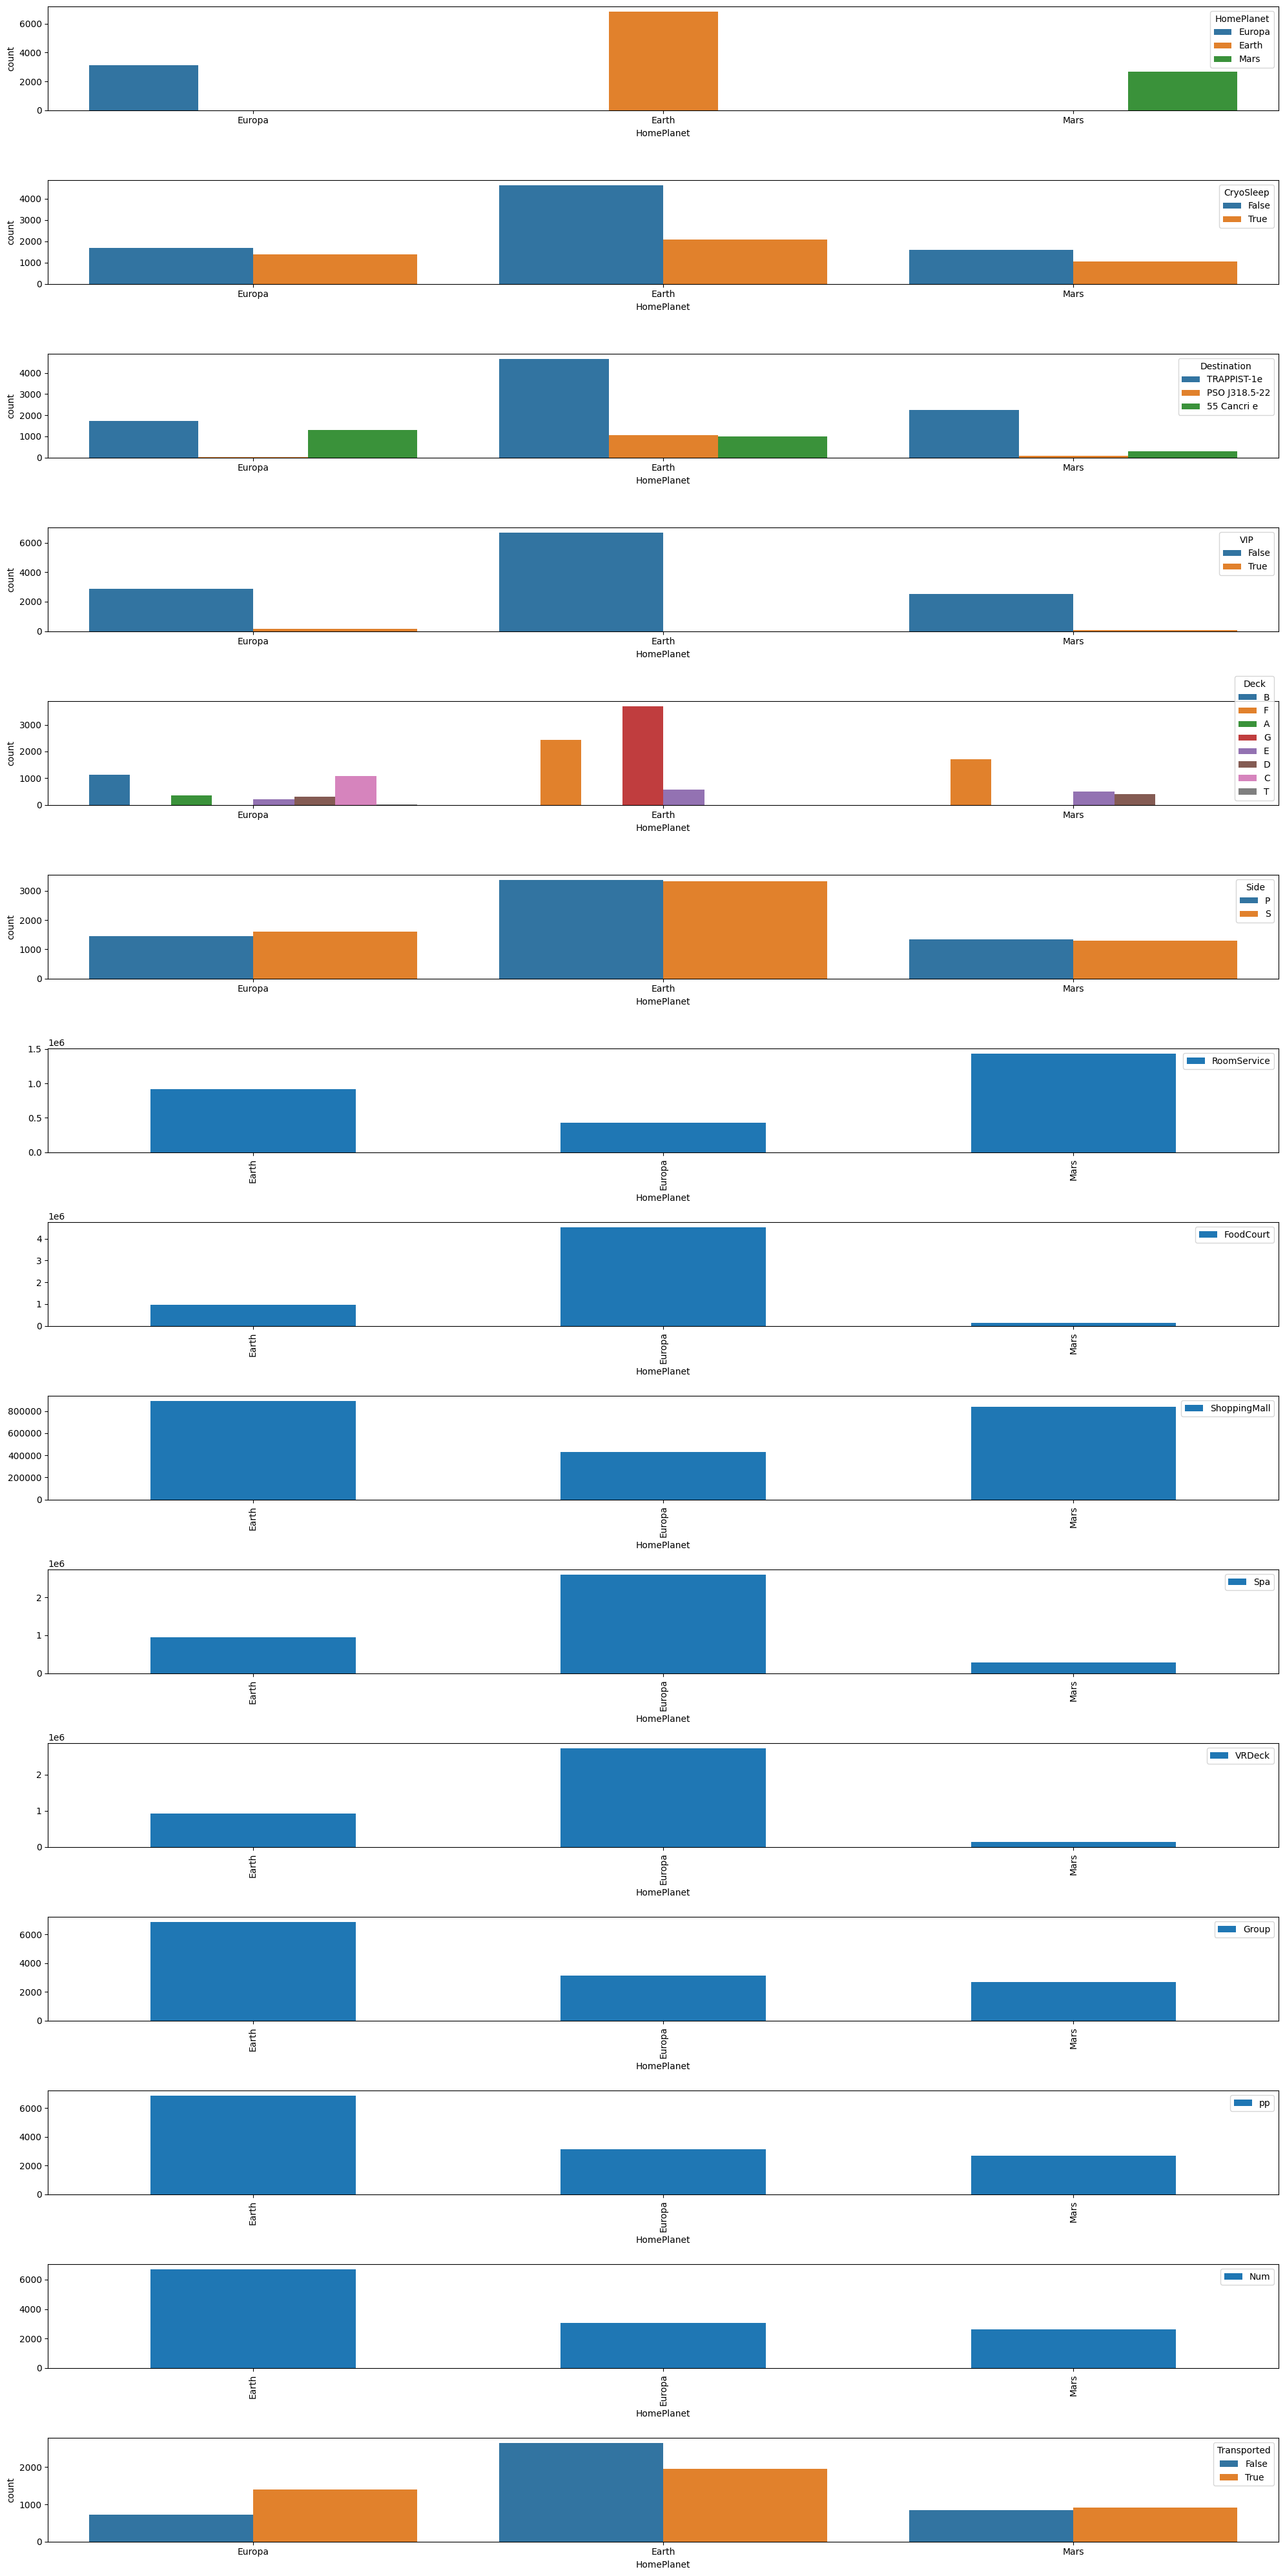

In [20]:
fig, ax = plt.subplots(15,figsize=(20,40))
sns.countplot(x='HomePlanet',hue='Transported',data=temp, ax=ax[14])
sns.countplot(x='HomePlanet',hue='HomePlanet',data=temp, ax=ax[0])
sns.countplot(x='HomePlanet',hue='CryoSleep',data=temp, ax=ax[1])
sns.countplot(x='HomePlanet',hue='Destination',data=temp, ax=ax[2])
sns.countplot(x='HomePlanet',hue='VIP',data=temp, ax=ax[3])
sns.countplot(x='HomePlanet',hue='Deck',data=temp, ax=ax[4])
sns.countplot(x='HomePlanet',hue='Side',data=temp, ax=ax[5])

temp.groupby('HomePlanet')['RoomService'].sum().plot(kind='bar', ax=ax[6], legend=True)
temp.groupby('HomePlanet')['FoodCourt'].sum().plot(kind='bar', ax=ax[7], legend=True)
temp.groupby('HomePlanet')['ShoppingMall'].sum().plot(kind='bar', ax=ax[8], legend=True)
temp.groupby('HomePlanet')['Spa'].sum().plot(kind='bar', ax=ax[9], legend=True)
temp.groupby('HomePlanet')['VRDeck'].sum().plot(kind='bar', ax=ax[10], legend=True)
temp.groupby('HomePlanet')['Group'].count().plot(kind='bar', ax=ax[11], legend=True)
temp.groupby('HomePlanet')['pp'].count().plot(kind='bar', ax=ax[12], legend=True)
temp.groupby('HomePlanet')['Num'].count().plot(kind='bar', ax=ax[13], legend=True)
fig.tight_layout()
plt.show()

In [21]:
temp[(temp.VIP == True) & (temp.HomePlanet == 'Earth')]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,pp,Deck,Num,Side,FirstName,LastName


In [22]:
temp[(temp.Destination == 'PSO J318.5-22') & (temp.HomePlanet == 'Europa')].shape

(29, 19)

In [23]:
temp.groupby('HomePlanet')['Deck'].unique()

HomePlanet
Earth              [F, G, nan, E]
Europa    [B, A, C, D, nan, E, T]
Mars               [F, D, E, nan]
Name: Deck, dtype: object

Important information which can help fill `nan` is that no one from Earth get VIP status also only passengers from Earth get 'G' Deck and from Europa Decks 'B', 'A', 'C'<br>

For only 29 passengers out of about 2000 departure from Europa,the destination is PSO J318.5-22

### **2.1.3 VIP --> expenses**

In [24]:
temp['Expenses'] = temp['RoomService'] +temp['FoodCourt'] + temp['ShoppingMall'] + temp['Spa'] + temp['VRDeck']

<AxesSubplot: xlabel='VIP'>

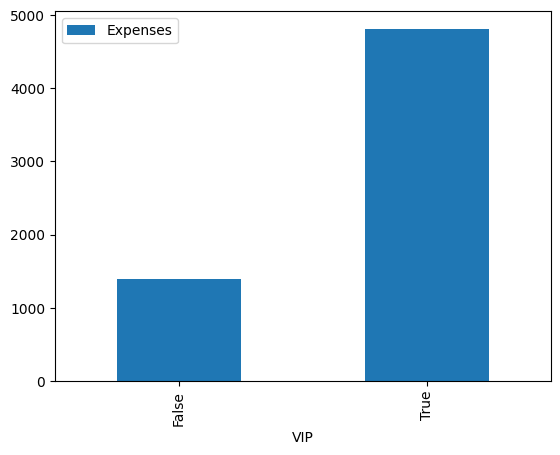

In [25]:
temp.groupby('VIP')['Expenses'].mean().plot(kind='bar', legend=True)

As we can see on `Age` and `HomePlanet` charts, the specific bill information does not give specific results therefore it will be collected into one column.<br>

`Expenses` `nan` can be filled by mean of expenses depending on VIP status

In [26]:
EXPENSES_COLUMNS = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
def combine_expenses(df):
    df['Expenses'] = 0
    for column in EXPENSES_COLUMNS:
        df['Expenses'] = df['Expenses'] + df[column]
    return df

### **2.1.4 CryoSleep**

<AxesSubplot: xlabel='CryoSleep'>

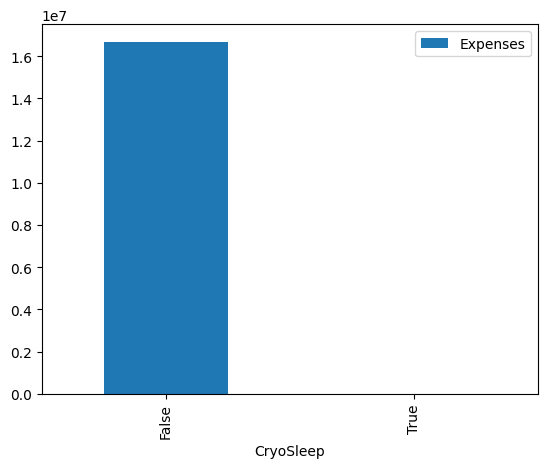

In [27]:
temp.groupby('CryoSleep')['Expenses'].sum().plot(kind='bar', legend=True)

In [28]:
temp[(temp.CryoSleep == True) & (temp.VIP == True)]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,pp,Deck,Num,Side,FirstName,LastName,Expenses
365,0402_01,NaN,True,55 Cancri e,32.0,True,0.0,0.0,0.0,0.0,0.0,True,0402,01,D,15,S,Teron,Sageng,0.0
589,0612_01,Europa,True,TRAPPIST-1e,27.0,True,0.0,0.0,0.0,0.0,0.0,True,0612,01,B,25,P,Achyon,Ranaly,0.0
1849,1976_03,Europa,True,55 Cancri e,26.0,True,0.0,0.0,0.0,0.0,0.0,True,1976,03,B,82,S,Cellah,Lansuffle,0.0
2394,2572_02,Europa,True,55 Cancri e,56.0,True,0.0,0.0,0.0,0.0,0.0,True,2572,02,C,93,S,Spuri,Suptibler,0.0
2675,2866_01,Europa,True,TRAPPIST-1e,36.0,True,0.0,0.0,0.0,0.0,0.0,True,2866,01,C,110,S,Hadirk,Wheededly,0.0
3104,3349_01,Europa,True,TRAPPIST-1e,73.0,True,0.0,0.0,0.0,NaN,0.0,True,3349,01,C,111,P,Sargin,Brakeril,NaN
4071,4348_01,Europa,True,TRAPPIST-1e,47.0,True,0.0,0.0,0.0,0.0,0.0,True,4348,01,B,142,P,Krazet,Conate,0.0
4155,4441_01,Europa,True,55 Cancri e,31.0,True,0.0,0.0,0.0,0.0,0.0,True,4441,01,B,144,P,Kabiton,Clinarfork,0.0
4401,4668_02,Europa,True,55 Cancri e,27.0,True,0.0,0.0,0.0,0.0,0.0,True,4668,02,C,180,S,Sadrus,Scerodbox,0.0
4503,4786_01,Europa,True,TRAPPIST-1e,46.0,True,0.0,0.0,0.0,0.0,0.0,True,4786,01,B,160,P,Enibah,Dratembid,0.0


Passengers in `CryoSleep` have no expenses and if they travel from `Europa` are VIP. 

### **2.1.5 Outliers**

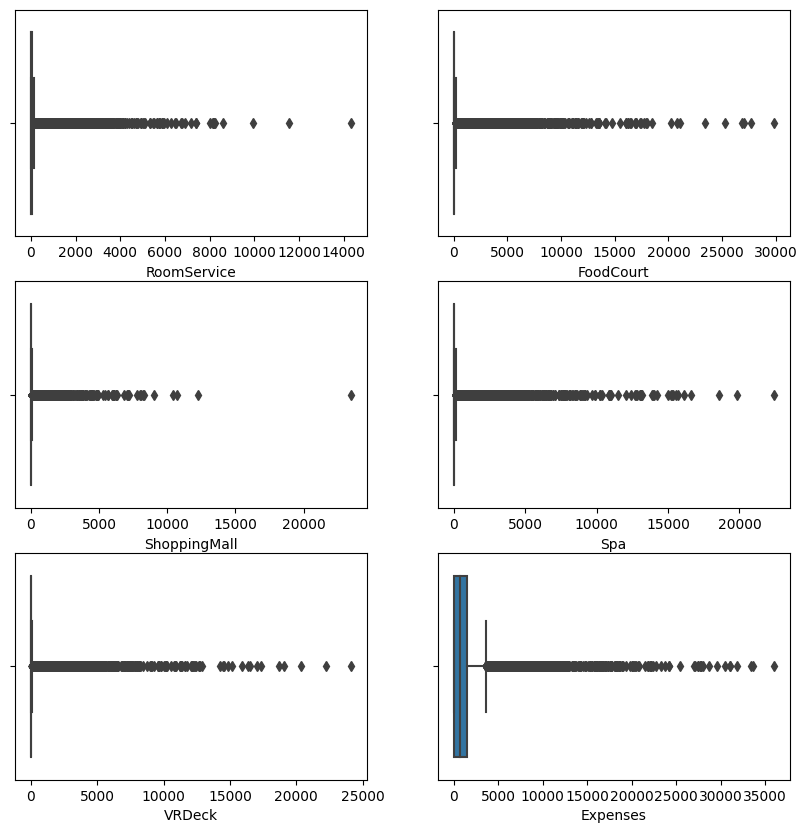

In [29]:
plt.figure(figsize=(10,10))
for i, feature in enumerate(EXPENSES_COLUMNS + ["Expenses"]):
    plt.subplot(3,2,i+1)
    sns.boxplot(x = temp[feature])


In [30]:
print(temp['RoomService'].mean())
print(temp[temp['RoomService'] > 0]['RoomService'].median())

222.89785157787045
313.5


In [31]:
print(temp['FoodCourt'].mean())
print(temp[temp['FoodCourt'] > 0]['FoodCourt'].median())

451.96167494677076
402.0


In [32]:
print(temp['ShoppingMall'].mean())
print(temp[temp['ShoppingMall'] > 0]['ShoppingMall'].median())

174.90603284902085
197.0


In [33]:
print(temp['Spa'].mean())
print(temp[temp['Spa'] > 0]['Spa'].median())

308.4769036733407
230.0


In [34]:
print(temp['VRDeck'].mean())
print(temp[temp['VRDeck'] > 0]['VRDeck'].median())

306.7894819713431
254.5


`Expenses` - due to many outliers `nan` will be filled by median because outliears exist also in test set.

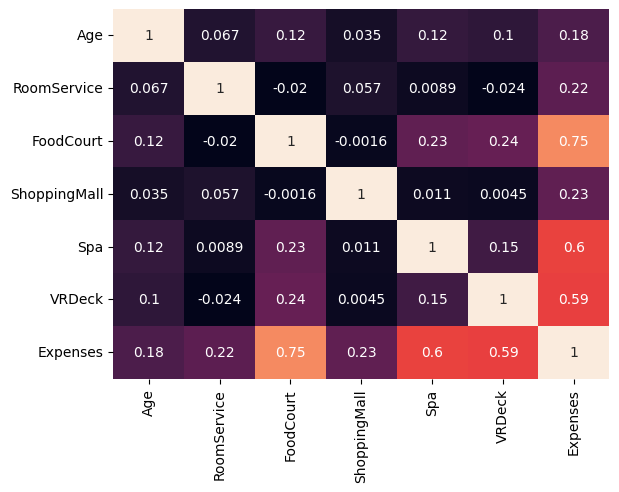

In [35]:
sns.heatmap(temp.corr(), annot=True, cbar=False)
plt.show()

## **2.2 Data cleaning**

#Describe steps based on previous analysis

In [36]:
train_test = pd.concat([train, test])

In [37]:
train_test = (train_test
              .pipe(split_cabin)
              .pipe(split_name)
              .pipe(split_passenger_id)
              )

In [38]:
train_test[train_test.duplicated()]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,FirstName,LastName,Group,pp


There is no duplicated rows between train and test set.

## **2.2.1 VIP**

In [39]:
train_test['VIP'] = np.where(train_test.VIP.isnull() & (train_test.Age < 25), False, train_test.VIP)

In [40]:
train_test['VIP'] = np.where(train_test.VIP.isnull() & train_test.HomePlanet.str.contains('Earth'), False, train_test.VIP)
train_test['VIP'] = np.where(train_test.VIP.isnull() & train_test.HomePlanet.str.contains('Europa'), True, train_test.VIP)

## **2.2.2 HomePlanet**

In [41]:
train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.Deck.str.contains('G'), 'Earth', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.Deck.str.contains('B'), 'Europa', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.Deck.str.contains('A'), 'Europa', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.Deck.str.contains('C'), 'Europa', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.VIP & train_test.Deck.str.contains('F'), 'Mars', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & (train_test.VIP==False), 'Earth', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.CryoSleep & train_test.VIP, 'Europa', train_test.HomePlanet)

## **2.2.3 Expenses**

In [42]:
for column in EXPENSES_COLUMNS:
    if_VIP_true = train_test[(train_test[column] > 0) & (train_test.VIP)][column].median()
    if_VIP_false = train_test[(train_test[column] > 0) & (train_test.VIP == False)][column].median()
    train_test[column] = np.where(train_test[column].isnull() & train_test.CryoSleep, 0, train_test[column])
    train_test[column] = np.where((train_test[column].isnull() )& (train_test.Age < 13), 0, train_test[column])
    train_test[column] = np.where(train_test[column].isnull() & (train_test.CryoSleep == False) & train_test.VIP, if_VIP_true, train_test[column])
    train_test[column] = np.where(train_test[column].isnull() & (train_test.CryoSleep == False), if_VIP_false, train_test[column])

In [43]:
train_test = combine_expenses(train_test)

## **2.2.4 CryoSleep**

In [44]:
train_test['CryoSleep'] = np.where(train_test.CryoSleep.isnull() & (train_test.Expenses == 0), True, train_test.CryoSleep)
train_test['CryoSleep'] = np.where(train_test.CryoSleep.isnull() & (train_test.Expenses > 0), False, train_test.CryoSleep)

## **2.2.5 Age**

In [45]:
train_test.Age.isnull().sum()

270

In [46]:
median_without_expenses = train_test[(train_test.Age < 13)]['Age'].median()

In [47]:
median_with_expenses = train_test[(train_test.Age > 12)]['Age'].median()

In [48]:
train_test['Age'] = np.where(train_test.Age.isnull() & (train_test.Expenses == 0), median_without_expenses, train_test.Age)
train_test['Age'] = np.where(train_test.Age.isnull() & (train_test.Expenses > 0), median_with_expenses, train_test.Age)

## **2.2.6 Destination**

No correlation found filled using `mode`

In [49]:
train_test.Destination.isnull().sum()

274

In [50]:
train_test['Destination'] = train_test.Destination.fillna(value=train_test.Destination.mode()[0])

In [51]:
train_test.Destination.isnull().sum()

0

## **2.2.7 Deck/Num/Side**

Number of `nan` in `Side` and `Num` is same because was created from one feature as `Deck` <br>
First I will try restore `Deck` values from `HomePlanet` were was 'G' for 'Earth' and 'B','A', 'C' for 'Europa' <br>

**Deck**

In [52]:
train_test[train_test.Deck.isnull()]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,FirstName,LastName,Group,pp,Expenses
15,0012_01,Earth,False,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,False,NaN,NaN,NaN,Justie,Pooles,0012,01,908.0
93,0101_01,Mars,True,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,Book,Trad,0101,01,0.0
103,0110_01,Europa,False,TRAPPIST-1e,32.0,False,0.0,410.0,6.0,3929.0,764.0,False,NaN,NaN,NaN,Graviph,Aloubtled,0110,01,5109.0
222,0239_01,Mars,False,TRAPPIST-1e,37.0,False,637.0,0.0,0.0,92.0,319.0,False,NaN,NaN,NaN,Diedow,Resty,0239,01,1048.0
227,0244_01,Mars,True,TRAPPIST-1e,43.0,False,0.0,0.0,0.0,0.0,0.0,True,NaN,NaN,NaN,Froos,Sad,0244,01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4209,9138_01,Europa,False,TRAPPIST-1e,41.0,False,0.0,1998.0,0.0,1023.0,867.0,NaN,NaN,NaN,NaN,Misamak,Trupistic,9138,01,3888.0
4248,9223_01,Mars,True,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Weessh,Sun,9223,01,0.0
4249,9223_02,Mars,True,TRAPPIST-1e,17.0,False,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Perit,Sun,9223,02,0.0
4258,9238_05,Earth,True,TRAPPIST-1e,14.0,False,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Caseye,Emenez,9238,05,0.0


In [53]:
train_test.groupby(['HomePlanet', 'VIP', 'Deck'])['Destination'].count()

HomePlanet  VIP    Deck
Earth       False  D         16
                   E        617
                   F       2522
                   G       3780
                   T          1
Europa      False  A        300
                   B       1061
                   C       1020
                   D        282
                   E        191
                   T          9
            True   A         54
                   B         80
                   C         82
                   D         15
                   E          6
                   T          1
Mars        False  D        369
                   E        478
                   F       1653
            True   D         29
                   E         22
                   F         41
Name: Destination, dtype: int64

Most common `Deck` for 'Mars' is 'F' that is why I decide to fill rest of `nan` by 'F'

In [54]:
train_test['Deck'] = np.where(train_test.Deck.isnull() & train_test.HomePlanet.str.contains('Earth'), 'G', train_test.Deck)
train_test['Deck'] = np.where(train_test.Deck.isnull() & train_test.HomePlanet.str.contains('Europa'), 'B', train_test.Deck)
train_test['Deck'] = np.where(train_test.Deck.isnull() & train_test.HomePlanet.str.contains('Mars'), 'F', train_test.Deck)

In [55]:
train_test.Deck.isnull().sum()

0

**Num/Side**

`num` and `Side` are same when `Group` and `LastName` are same

In [56]:
train_test['Num'] = np.where(train_test.Num.isnull() & train_test.LastName.eq(train_test.LastName.shift()), train_test.Num.shift(), train_test.Num)
train_test['Side'] = np.where(train_test.Side.isnull() & train_test.LastName.eq(train_test.LastName.shift()), train_test.Side.shift(), train_test.Side)

Other `nan` will be made up `mode` function

In [57]:
train_test['Num'] = train_test.Num.fillna(value=train_test.Num.mode()[0])
train_test['Side'] = train_test.Side.fillna(value=train_test.Side.mode()[0])

## **2.2.8 LastName**

In [58]:
train_test['LastName'] = np.where(train_test.LastName.isnull(), train_test.LastName.shift(), train_test.LastName)


In [59]:
train_test.LastName.isnull().sum()

11

## **2.2.9 Repeat steps**
Repetition of the steps is necessary because on the `nan` completed in the next steps were the basis for filling in the previous gaps.

**VIP**

In [60]:
train_test['VIP'] = np.where(train_test.VIP.isnull() & (train_test.Age < 25), False, train_test.VIP)
train_test['VIP'] = np.where(train_test.VIP.isnull() & train_test.HomePlanet.str.contains('Earth'), False, train_test.VIP)

**HomePlanet**

In [61]:
train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.Deck.str.contains('G'), 'Earth', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.Deck.str.contains('B'), 'Europa', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.Deck.str.contains('A'), 'Europa', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.Deck.str.contains('C'), 'Europa', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.VIP & train_test.Deck.str.contains('F'), 'Mars', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & (train_test.VIP==False), 'Earth', train_test.HomePlanet)

train_test['HomePlanet'] = np.where(train_test.HomePlanet.isnull() & train_test.CryoSleep & train_test.VIP, 'Europa', train_test.HomePlanet)

**Expenses**

In [62]:
for column in EXPENSES_COLUMNS:
    if_VIP_true = train_test[(train_test[column] > 0) & (train_test.VIP)][column].median()
    if_VIP_false = train_test[(train_test[column] > 0) & (train_test.VIP == False)][column].median()
    train_test[column] = np.where(train_test[column].isnull() & train_test.CryoSleep, 0, train_test[column])
    train_test[column] = np.where((train_test[column].isnull() )& (train_test.Age < 13), 0, train_test[column])
    train_test[column] = np.where(train_test[column].isnull() & (train_test.CryoSleep == False) & train_test.VIP, if_VIP_true, train_test[column])
    train_test[column] = np.where(train_test[column].isnull() & (train_test.CryoSleep == False), if_VIP_false, train_test[column])

In [63]:
train_test = combine_expenses(train_test)

**CryoSleep**

In [64]:
train_test['CryoSleep'] = np.where(train_test.CryoSleep.isnull() & (train_test.Expenses == 0), True, train_test.CryoSleep)
train_test['CryoSleep'] = np.where(train_test.CryoSleep.isnull() & (train_test.Expenses > 0), False, train_test.CryoSleep)

<AxesSubplot: >

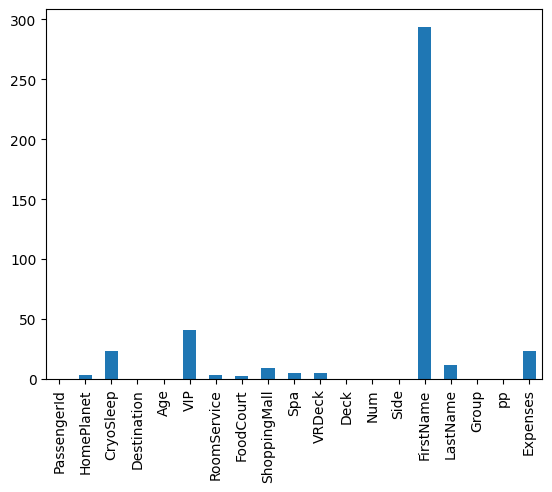

In [65]:
train_test.drop('Transported', axis=1).isna().sum().plot(kind='bar')

In [66]:
train_test.drop(['FirstName'], axis=1, inplace=True)

## **2.2.10 Drop `nan`**

In [67]:
get_number_of_null_cells_in_row(train_test.drop('Transported', axis=1))

0    12893
1       53
3       22
4        1
2        1
dtype: int64

`nan` in test set

In [68]:
get_number_of_null_cells_in_row(train_test[train_test.Transported.isnull()])

1    4251
2      21
4       5
dtype: int64

In [69]:
train = train_test[~train_test.Transported.isnull()].dropna().copy()
test = train_test[train_test.Transported.isnull()].copy()

In [70]:
get_number_of_null_cells_in_row(train)

0    8642
dtype: int64

1841 rows has been restored by filling `nan` in train dataset

## **2.3 Feature Engineering**

In [71]:
train_test = pd.concat([train, test])

In [72]:
train_test.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'Deck', 'Num', 'Side', 'LastName', 'Group', 'pp',
       'Expenses'],
      dtype='object')

In [73]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12919 entries, 0 to 4276
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12919 non-null  object 
 1   HomePlanet    12918 non-null  object 
 2   CryoSleep     12914 non-null  object 
 3   Destination   12919 non-null  object 
 4   Age           12919 non-null  float64
 5   VIP           12906 non-null  object 
 6   RoomService   12918 non-null  float64
 7   FoodCourt     12919 non-null  float64
 8   ShoppingMall  12917 non-null  float64
 9   Spa           12918 non-null  float64
 10  VRDeck        12918 non-null  float64
 11  Transported   8642 non-null   object 
 12  Deck          12919 non-null  object 
 13  Num           12919 non-null  object 
 14  Side          12919 non-null  object 
 15  LastName      12912 non-null  object 
 16  Group         12919 non-null  object 
 17  pp            12919 non-null  object 
 18  Expenses      12914 non-nul

In [74]:
train_test = group_age(train_test)

In [75]:
train_test.VIP = train_test.VIP.replace({True : 1, False : 0})
train_test.CryoSleep = train_test.CryoSleep.replace({True : 1, False : 0})
train_test.Side = train_test.Side.replace({'P' : 1, 'S' : 0}) 

In [76]:
categorical = ['Age', 'LastName', 'Num','Group', 'pp']  # deleted pp
for column in categorical:
    encoder = LabelEncoder()
    train_test[column] = encoder.fit_transform(train_test[column])

In [77]:
train_test = pd.get_dummies(train_test, columns=['HomePlanet', 'Destination', 'Deck'])

In [78]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12919 entries, 0 to 4276
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                12919 non-null  object 
 1   CryoSleep                  12914 non-null  float64
 2   Age                        12919 non-null  int64  
 3   VIP                        12906 non-null  float64
 4   RoomService                12918 non-null  float64
 5   FoodCourt                  12919 non-null  float64
 6   ShoppingMall               12917 non-null  float64
 7   Spa                        12918 non-null  float64
 8   VRDeck                     12918 non-null  float64
 9   Transported                8642 non-null   object 
 10  Num                        12919 non-null  int64  
 11  Side                       12919 non-null  int64  
 12  LastName                   12919 non-null  int64  
 13  Group                      12919 non-null  int6

## **2.3.1 Data splitting**

In [79]:
train_test.reset_index(drop=True, inplace=True)
train = train_test[~train_test.Transported.isnull()].copy().astype('float64')

test = train['Transported'].copy().astype('float64')
train = train.drop(labels=['PassengerId', 'Transported'], axis=1)

submission_test = train_test[train_test.Transported.isnull()].copy()
submission = submission_test.PassengerId.copy()
submission_test = submission_test.drop(labels =['PassengerId', 'Transported'], axis=1)

In [80]:
X_train, X_test,y_train, y_test = train_test_split(train,test, test_size=0.2, random_state=42)

X_train, X_val,y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)

<AxesSubplot: ylabel='Transported'>

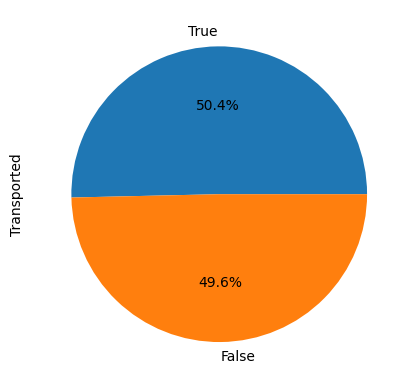

In [82]:
train_test[~train_test.Transported.isnull()]['Transported'].value_counts().plot(kind='pie', autopct='%1.1f%%')

After data cleaning dataset balance stay same as before

# **3.Models**

The algorithms it will use:<br>
    XGBoost<br>
    LightGBM<br>
    CatBoost<br>
    
Neural Network:<br>
    PyTorch logistic regression

## **3.1 Machine Learning algorithms**

In [83]:
def kfold_mean(model, n_splits):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    scores = []

    for train_idx, test_idx in kf.split(train):

        X_train, X_test = train.iloc[train_idx], train.iloc[test_idx]
        y_train, y_test = test[train_idx], test[test_idx]

        preds = model.predict(X_test)
        loss = accuracy_score(y_test, preds)
        scores.append(loss)
    accuracy = np.mean(scores)
    print(f"KFold mean score: {accuracy}")
    return accuracy

In [84]:
def calculate_metrics(y_test, preds):
    accuracy = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    return accuracy, recall, precision, f1

## **3.1.1 XGBoost**

In [86]:
def objective(trial):

    params = {
        #Parameters to tune
        'n_estimators': trial.suggest_int('n_estimators', 50, 3000),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        
        #Parameters for faster speed
        'colsample_bytree' : trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        
        #Parameters to control overfitting
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'early_stopping_rounds' : trial.suggest_int('early_stopping_rounds',5,30),
        
        
        #Loss function and evaluation metric
        'objective' : 'binary:logistic', 
        'eval_metric': 'logloss', 
        
        #'tree_method' : 'gpu_hist'
    
    }
    
    
    # Fit the model
    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(X_train, y_train, verbose=False, eval_set=[(X_val, y_val)])

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [87]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

CPU times: user 9min 9s, sys: 3min 15s, total: 12min 24s
Wall time: 1min 46s


In [88]:
xgbc = xgb.XGBClassifier(**study.best_trial.params)
xgbc.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False) 
kfold_acc = kfold_mean(xgbc,10)

KFold mean score: 0.845065697923357


In [89]:
accuracy, recall, precision, f1 = calculate_metrics(y_test, xgbc.predict(X_test))

xgbc_metrics = {'Model': 'XGBoost','KFold cv accuracy': kfold_acc ,'Accuracy': accuracy, 'recall': recall, 'precision': precision, 'f1': f1}

## **3.1.2 LightGBM**

In [90]:
def objective(trial):

    params={
    #Parameters to tune
    'num_leaves' : trial.suggest_int('num_leaves',2,800), #should be less than 2^max_depth lower better acc
    'max_depth' : trial.suggest_int('max_depth', 1, 15),
    'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 0, 400),
    
    #Parameters for better accurancy
    'max_bin' : trial.suggest_int('max_bin',100,600), #small number of bins may reduce training accuracy 
                                                    #but may increase general power (deal with over-fitting)
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
    
    #Parameters to control over-fitting
    'min_gain_to_split' : trial.suggest_loguniform('min_gain_to_split', 1.0, 10.0),
    'early_stopping' : trial.suggest_int('early_stopping_rounds',5,30),
    
    #Loss function and evaluation metric
    'objective' : 'binary', 
    'metric': 'binary_logloss', 
    
    #Other    
    'device_type' : 'CPU',
    'n_jobs' : -1,
    'verbose' : -1,
    'verbose_eval' : -1
}
    
    
    # Fit the model
    optuna_model = lgbm.LGBMClassifier(**params)
    optuna_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [ ]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

In [92]:
trial = study.best_trial
lgbmc = lgbm.LGBMClassifier(**trial.params)
lgbmc.fit(X_train, y_train, eval_set=[(X_val, y_val)],verbose=False,)
kfold_acc = kfold_mean(lgbmc, 10)

[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_gain_to_split is set=2.224001500633828, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.224001500633828
[LightGBM] [Warning] lambda_l1 is set=0.6090614382171639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6090614382171639
[LightGBM] [Warning] early_stopping_round is set=26, early_stopping_rounds=26 will be ignored. Current value: early_stopping_round=26
KFold mean score: 0.8262002247912651


In [93]:
accuracy, recall, precision, f1 = calculate_metrics(y_test, lgbmc.predict(X_test))

lgbmc_metrics = {'Model': 'LightGBM','KFold cv accuracy': kfold_acc ,'Accuracy': accuracy, 'recall': recall, 'precision': precision, 'f1': f1}

## **3.1.3 CatBoost**

In [94]:
def objective(trial):
    params={
    #Parameters to tune
    'iterations' : trial.suggest_int('iterations',100,2000),
    'depth' : trial.suggest_int('depth', 1, 15),    
    'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 0, 200),
    
    #Parameters to control overfitting
    'early_stopping_rounds': trial.suggest_int('early_stopping_rounds',5,30),
    'od_type' : trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        
    #loss function and evaluation metric
    'objective' : trial.suggest_categorical("objective", ['Logloss']),
    'eval_metric' : trial.suggest_categorical('eval_metric',['Accuracy']),
    
    #'task_type' : 'GPU,'
    'verbose' : False
}
    
    
    # Fit the model
    optuna_model = cb.CatBoostClassifier(**params)
    optuna_model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [95]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

CPU times: user 1h 32min 15s, sys: 15min 32s, total: 1h 47min 47s
Wall time: 15min 53s


In [96]:
cbc = cb.CatBoostClassifier(**study.best_trial.params)
cbc.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
kfold_acc = kfold_mean(cbc, 10)

KFold mean score: 0.8553648843930637


In [97]:
accuracy, recall, precision, f1 = calculate_metrics(y_test, cbc.predict(X_test))

cbc_metrics = {'Model': 'CatBoost','KFold cv accuracy': kfold_acc ,'Accuracy': accuracy, 'recall': recall, 'precision': precision, 'f1': f1}

## **3.2.1 Summary**

In [98]:
metrics = pd.DataFrame([xgbc_metrics, lgbmc_metrics, cbc_metrics]).set_index('Model', drop=True)
(metrics.style
    .highlight_min('f1', color='red')
    .highlight_max('f1', color='lightgreen')
    .highlight_min('precision', color='red')
    .highlight_max('precision', color='lightgreen')
    .highlight_min('recall', color='red')
    .highlight_max('recall', color='lightgreen')
    .highlight_min('Accuracy', color='red')
    .highlight_max('Accuracy', color='lightgreen')
    .highlight_min('KFold cv accuracy', color='red')
    .highlight_max('KFold cv accuracy', color='lightgreen')
     
)

,KFold cv accuracy,Accuracy,recall,precision,f1
Model,,,,,
XGBoost,0.845066,0.816079,0.814480,0.823799,0.819113
LightGBM,0.826200,0.814922,0.847285,0.801927,0.823982
CatBoost,0.855365,0.823597,0.837104,0.821310,0.829132


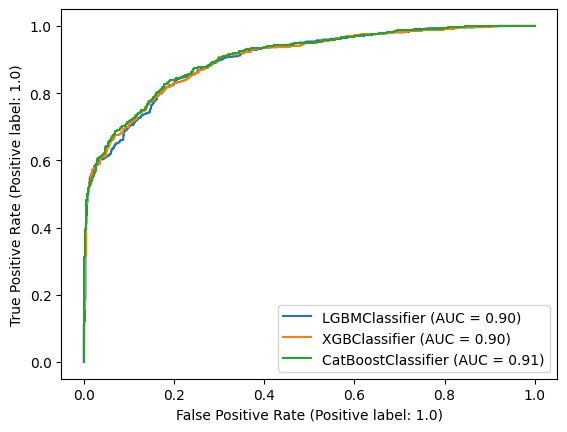

In [99]:
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(lgbmc, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(xgbc, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(cbc, X_test, y_test, ax=ax)
plt.show()

## **3.2.2 Conclusions**

XGBoost had the highest precision values an LightGBM had highest recall but CatBoost outperformed it in terms of accuracy, AUC and f1 score.

CatBoost had the highest cv accuracy, which suggests that it is more robust to variations in the data. Additionally, CatBoost had a high f1 score, which indicates a good balance between precision and recall that is why will be used to submission.

## **3.2.3 Submission**

In [100]:
#submission using CatBoost
sub_pred_cbc = cbc.predict(submission_test)

sub_pred_cbc = sub_pred_cbc.astype('bool')

In [101]:
sub = pd.read_csv('data/sample_submission.csv')

sub['Transported'] = sub_pred_cbc

sub.to_csv('data/submission.csv', index=False)

## **3.3 PyTorch**

In [102]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [103]:
# Model
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs
        
#Create model
model = LogisticRegression(X_train.shape[1], 1).to(device)
print(model)

LogisticRegression(
  (linear): Linear(in_features=28, out_features=1, bias=True)
)


In [104]:
#loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [105]:
#k-fold parameters
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [106]:
%%time
#Cross-Validation
scores = []
for train_index, test_index in kf.split(train):
    X_train, X_test = torch.Tensor(train.iloc[train_index,:].values), torch.Tensor(train.iloc[test_index,:].values)
    y_train, y_test = torch.Tensor(test[train_index].values), torch.Tensor(test[test_index].values)

 # Model Training
    losses = []
    losses_test = []
    Iterations = []
    iter = 0
    epochs = 20000
    for epoch in range(int(epochs)):
        x =  X_train.to(device)
        labels =  y_train.to(device)
        optimizer.zero_grad() # Setting our stored gradients equal to zero
        outputs = model(x)
        loss = criterion(torch.squeeze(outputs), labels) 

        loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
        optimizer.step() # Updates weights and biases with the optimizer (SGD)

    with torch.no_grad():
        # Calculating the loss and accuracy for the test dataset
        correct_test = 0
        total_test = 0
        outputs_test = torch.squeeze(model(X_test.to(device)))
        predicted_test = outputs_test.cpu().round().detach().numpy()
        total_test += y_test.size(0)
        correct_test += np.sum(predicted_test == y_test.detach().numpy())
        accuracy_test = 100 * correct_test/total_test
        scores.append(accuracy_test)
    accuracy = np.mean(scores)
    
print(f"{device} KFold mean accuracy score: {accuracy}\n")

cpu KFold mean accuracy score: 78.33832423463926

CPU times: user 41.9 s, sys: 3.67 s, total: 45.6 s
Wall time: 42.2 s
